In [22]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# reading h5 file
f1 = 'dataset/file1000612.h5'
data1 = h5py.File(f1)

In [8]:
print("Keys: ", list(data1.keys()))
print("Attr: ", dict(data1.attrs))

print(data1['kspace'])

Keys:  ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attr:  {'acquisition': 'CORPDFS_FBK', 'max': 0.0003239908310284407, 'norm': 0.09130722957017874, 'patient_id': '7a030f688bf16ce82f73c9cfc7c16091da6eb0b3745f2ed01c16cdc2ab1fe665'}
<HDF5 dataset "kspace": shape (45, 15, 640, 372), type "<c8">


In multi-coil MRIs, k-space has the following shape: (number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape: (number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [9]:
kspace = data1['kspace'][()]
print(kspace.dtype)
print(kspace.shape)

complex64
(45, 15, 640, 372)


In [44]:
# 20th slice of the data
kspace20 = kspace[20]
print("Shape = ", kspace20.shape)


Shape =  (15, 640, 372)


Showing Data

In [45]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure() # from https://github.com/facebookresearch/fastMRI/blob/main/fastMRI_tutorial.ipynb
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap='viridis', aspect='auto')

    # Create a figure with subplots
    # rows = len(slice_nums)
    # cols = data.shape[1]  # Choose the number of columns as needed
    # fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    #
    # for i, num in enumerate(slice_nums):
    #     for j in range(data.shape[1]):  # Iterate over the second dimension
    #         # Select a 2D slice from the 4D data
    #         slice_data = data[num, j, :, :]
    #         # Display the slice in the corresponding subplot
    #         ax = axes[i, j]
    #         ax.imshow(slice_data, cmap=cmap)
    #         ax.set_title(f"Slice {num}, Channel {j}")
    #         ax.axis('off')  # Turn off axis labels and ticks
    #
    # plt.show()

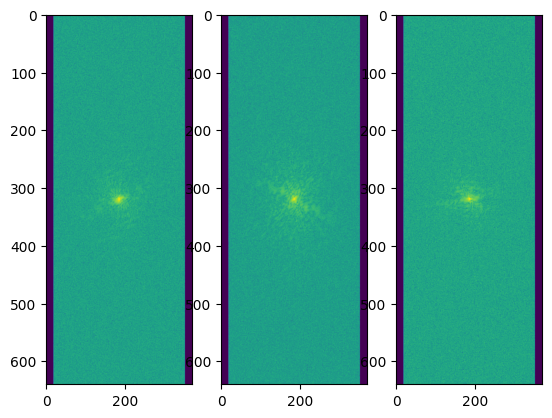

In [46]:
show_coils(np.log(np.abs(kspace20) + 1e-9), [0, 5, 10]) # coil number 0, 5, 10

Fourier Transformation of kspace to complex images.

In [47]:
import fastmri
from fastmri.data import transforms as T

In [55]:
kspace20t = T.to_tensor(kspace20)
transformed_data20 = fastmri.ifft2c(kspace20t)
transformed_data20_abs = fastmri.complex_abs(transformed_data20)
print("Data shapes: \nKspace: {} \nTransformed {} ".format(kspace20t.shape, transformed_data20.shape))

Data shapes: 
Kspace: torch.Size([15, 640, 372, 2]) 
Transformed torch.Size([15, 640, 372, 2]) 


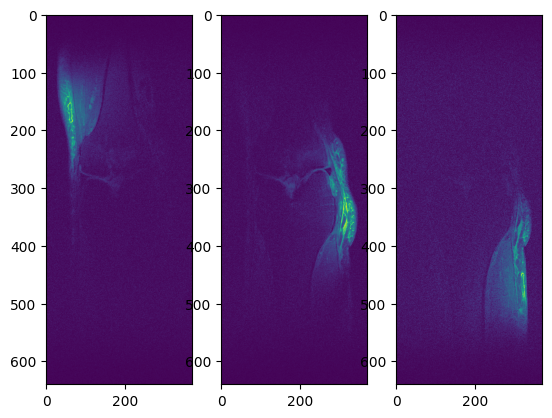

In [56]:
show_coils(transformed_data20_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

ABS: torch.Size([15, 640, 372])
RSS: torch.Size([640, 372])


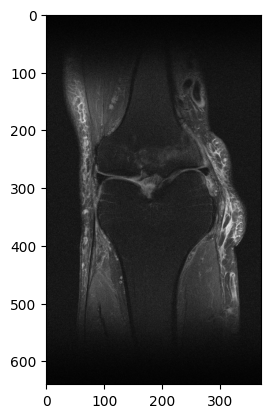

In [58]:
transformed_data20_rss = fastmri.rss(transformed_data20_abs, dim=0)
print("ABS: {}\nRSS: {}".format(transformed_data20_abs.shape, transformed_data20_rss.shape))
plt.imshow(np.abs(transformed_data20_rss.numpy()), cmap='gray')